In [2]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import yfinance as yf

# https://github.com/andrewcharlesjones/universal_portfolios/blob/master/universal_portfolio.ipynb


# In his paper, Cover shows that, over a long enough time period, this strategy is guaranteed to perform as well
# as the best constant rebalanced portfolio in hindsight.

In [17]:
### GET STOCK DATA

tickers = ['AAPL', 'TSLA', 'KO', 'WBA', 'WMT','MAC', 'DKS', 'GOOGL', 'MSFT', 'TWTR' ,'GME','NVDA']
num_stocks = len(tickers)

data_mat = []

for ticker in tickers:
    data = yf.download(ticker, '2016-01-01', '2021-02-15') #,'2018-01-01')
    data_mat.append(data.Close.values / data.Open.values)
    
data = np.array(data_mat)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [18]:
data_mat[0].min() , data_mat[0].max() , data_mat[0].argmin() , data_mat[0].argmax()
# argmin and argmax for numpy array act as idxmin and idxmax for pandas 

(0.9274213621077797, 1.0625825039834418, 1061, 1046)

In [20]:
data_mat[11].min() , data_mat[11].max() , data_mat[11].argmin() , data_mat[11].argmax()

(0.8943692623333866, 1.1138744528821811, 727, 1046)

In [23]:
data.min() , data.max() , data.argmin() ,data.argmax()

(0.586687121040228, 1.6709575407297341, 14172, 14165)

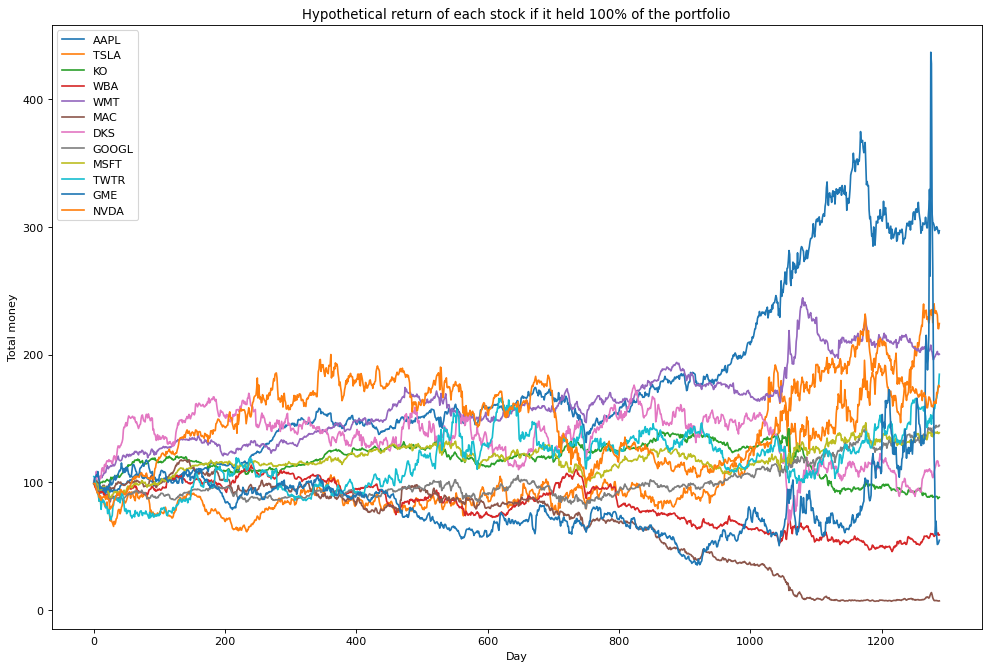

In [25]:
# Get hypothetical returns of each stock if that stock got all the money

initial_money = 100 # start with $100
overall_returns = 100 * np.cumprod(data, axis=1)

plt.figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
for ii in range(data.shape[0]):
    plt.plot(overall_returns[ii, :], label = tickers[ii])
plt.legend()
plt.xlabel("Day")
plt.ylabel("Total money")
plt.title("Hypothetical return of each stock if it held 100% of the portfolio")
#plt.savefig("./unistock_portfolio_returns.png")
plt.show()

In [44]:
# gets the total return for a given portfolio b
def portfolio_wealth(b, stock_data):
    return np.prod(np.dot(b, stock_data))

# function for retrieving all possible portfolios at a certain level of granularity
def binnings(n, k, cache={}):
    if n == 0:
        return np.zeros((1, k))
    if k == 0:
        return np.empty((0, 0))
    args = (n, k)
    if args in cache:
        return cache[args]
    a = binnings(n - 1, k, cache)
    a1 = a + (np.arange(k) == 0)
    b = binnings(n, k - 1, cache)
    b1 = np.hstack((np.zeros((b.shape[0], 1)), b))
    result = np.vstack((a1, b1))
    cache[args] = result
    return result

In [46]:
## COMPUTE ALL POSSIBLE PORTFOLIOS

allocation_granularity = 10
all_portfolio_allocations = binnings(allocation_granularity, num_stocks) # (10 , 12)
row_sums = all_portfolio_allocations.sum(axis=1)
all_portfolios = all_portfolio_allocations / row_sums[:, np.newaxis]

In [52]:
all_portfolio_allocations , row_sums , all_portfolios , row_sums[:, np.newaxis]

(array([[10.,  0.,  0., ...,  0.,  0.,  0.],
        [ 9.,  1.,  0., ...,  0.,  0.,  0.],
        [ 9.,  0.,  1., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  2.,  8.],
        [ 0.,  0.,  0., ...,  0.,  1.,  9.],
        [ 0.,  0.,  0., ...,  0.,  0., 10.]]),
 array([10., 10., 10., ..., 10., 10., 10.]),
 array([[1. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0.9, 0.1, 0. , ..., 0. , 0. , 0. ],
        [0.9, 0. , 0.1, ..., 0. , 0. , 0. ],
        ...,
        [0. , 0. , 0. , ..., 0. , 0.2, 0.8],
        [0. , 0. , 0. , ..., 0. , 0.1, 0.9],
        [0. , 0. , 0. , ..., 0. , 0. , 1. ]]),
 array([[10.],
        [10.],
        [10.],
        ...,
        [10.],
        [10.],
        [10.]]))

In [57]:
## RUN UNIVERSAL PORTFOLIO

initial_money = 100
curr_portfolio = np.ones(data.shape[0]) * 1.0 / data.shape[0] # uniform
used_portfolios = []
money_per_stock = []
total_money_trace = []
money_per_stock.append(curr_portfolio * initial_money)
used_portfolios.append(curr_portfolio)

## run the algorithm  , took ONE HOUR to run 
for tt in range(data.shape[1]):
    
    ## calculate returns
    curr_return = np.multiply(data[:, tt], money_per_stock)
    total_money = np.sum(curr_return)
    total_money_trace.append(total_money)
    
    ## compute the updated portfolio
    portfolio_weights = np.array([portfolio_wealth(x, data[:, :tt+1]) for x in list(all_portfolios)])
    weighted_portfolio = np.dot(portfolio_weights, all_portfolios)
    curr_portfolio = weighted_portfolio / np.sum(portfolio_weights)
    used_portfolios.append(curr_portfolio)
    
    ## rebalance the money
    money_per_stock = curr_portfolio * total_money
    

    
## compute the best "buy and hold" strategy
buy_and_hold_returns = np.prod(data, axis=1)
    
## compute the best constant rebalanced portfolio in hindsight

In [58]:
data.shape[0] , data.shape[1]

(12, 1289)

In [60]:
print(buy_and_hold_returns * initial_money)
print(np.sum(money_per_stock))
print(curr_portfolio)

[297.08675842 224.33185459  88.12852918  58.69699313 200.32976189
   6.93377086 112.92251219 144.60682013 138.71506519 184.58807
  54.42671644 174.8952483 ]
140.38903540845186
[0.09570824 0.09450877 0.07799722 0.07343511 0.08966018 0.05466047
 0.08314363 0.08442207 0.0838526  0.09039849 0.08333702 0.08887619]


In [64]:
## compute earnings for buy and holds

buy_and_hold_money = initial_money * np.cumprod(data, axis=1)
buy_and_hold_money

array([[ 98.36463885, 100.9912727 ,  98.08807117, ..., 296.52834735,
        294.84826214, 297.08675842],
       [100.62890285,  97.44063062,  96.17936389, ..., 220.45886435,
        220.24720026, 224.33185459],
       [ 99.21478023,  99.35538068,  99.91896089, ...,  87.06342919,
         87.91990165,  88.12852918],
       ...,
       [104.3752788 , 104.0064619 , 100.0360492 , ..., 174.54996131,
        176.01331516, 184.58807   ],
       [ 98.6282118 , 103.26052252, 103.91064233, ...,  51.58849211,
         52.71289655,  54.42671644],
       [ 98.86022476,  99.10514955,  98.83469841, ..., 172.81223054,
        175.93272174, 174.8952483 ]])

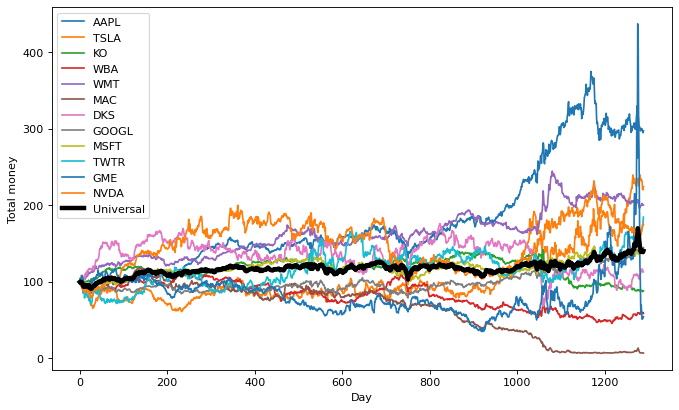

In [65]:
# ## compare buy and hold to universal portfolio

plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')


for ii in range(buy_and_hold_money.shape[0]):
    plt.plot(buy_and_hold_money[ii, :], label = tickers[ii])
    
plt.plot(total_money_trace, 'black', label="Universal", linewidth=4)
plt.legend()
plt.xlabel("Day")
plt.ylabel("Total money")
#plt.savefig('./universal_vs_bh.png')
plt.show()

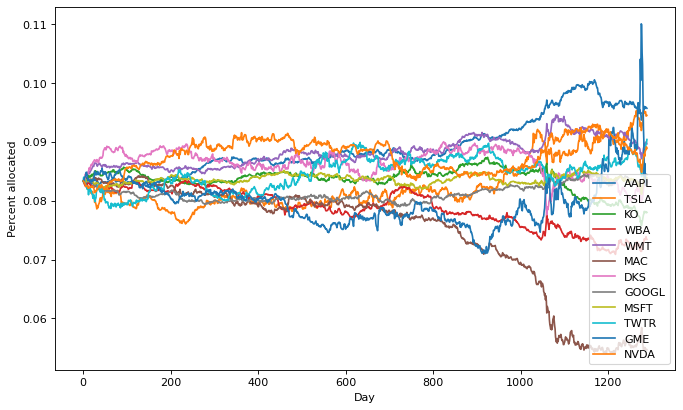

In [66]:
## look at evolution of universal portfolio over time

plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')

used_portfolios = np.array(used_portfolios)

for ii in range(used_portfolios.shape[1]):
    
    plt.plot(used_portfolios[:, ii], label = tickers[ii])
    
plt.xlabel("Day")
plt.ylabel("Percent allocated")
plt.legend()
#plt.savefig('./universal_over_time.png')
plt.show()

In [67]:
# calculate returns for each constant balanced portfolio
portfolio_hindsight_earnings = []
for p in all_portfolios:
    curr_w = portfolio_wealth(p, data)
    portfolio_hindsight_earnings.append(curr_w)

In [68]:
np.max(portfolio_hindsight_earnings) * 100

301.9421831210982

In [69]:
# check best constant balanced portfolio
all_portfolios[np.argmax(portfolio_hindsight_earnings)]

array([0.8, 0.2, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ])

In [70]:
curr_w

1.7489524829799292